# Injury Risk Data Preparation (Bayesian Network)

In this notebook, we're going to load, clean, and preprocess data from three different sources:
1.  `athletes.csv`: Static data about each athlete (age, experience, etc.)
2.  `daily_data.csv`: Daily wellness metrics (sleep, stress, HRV, etc.)
3.  `activity_data.csv`: Individual training session data (intensity, load, etc.)

The goal is to perform feature engineering to create variables relevant to injury risk (like ACWR, readiness, and injury history) and then discretize them to make the dataset suitable for a Bayesian Network implementation.

- [Setup](#Setup)
- [Loading & Normalization](#Loading--Normalization)
- [Baseline Variables](#Baseline-Variables-from-athletecsv)
- [Feature Engineering (Activity)](#Feature-Engineering-from-activity_data)
- [Merge & Initial Inspection](#Merge--Initial-Inspection)
- [Feature Engineering (Post-Merge)](#Feature-Engineering-Post-Merge)
- [Discretization](#Discretization)
- [NaN Handling](#NaN-Handling-for-BN)
- [Export](#Export)

## ============================== Setup ======================================

This first block imports the necessary libraries (`pandas`, `numpy`, `os`) and defines the file paths. It also contains several helper functions that we will use later for:
* `find_col`: Safely finding column names even if they are spelled differently (e.g., "athlete_id" vs "Athlete_ID").
* `grouped_rolling_mean`: Calculating rolling averages grouped by each athlete.
* `zscore_by_group`: Normalizing metrics (like HRV) based on each athlete's own baseline.
* `discretize_qcut`: A robust function to bin continuous data into quantiles (e.g., "Low", "Medium", "High").

In [72]:
import os
import numpy as np
import pandas as pd

# Paths
ATHLETES_CSV = "data/athletes.csv"
DAILY_CSV    = "data/daily_data.csv"
ACTIVITY_CSV = "data/activity_data.csv"

# Output filename
OUT_CSV = "bn_preprocessed.csv"

# Utility: find a "close" column name with fallback
def find_col(df, candidates, required=False):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    if required:
        raise KeyError(f"Could not find any of {candidates} in {list(df.columns)[:20]}...")
    return None

# Utility: rolling mean by group
def grouped_rolling_mean(s, group, window, min_periods=1):
    return s.groupby(group, group_keys=False).rolling(window, min_periods=min_periods).mean().reset_index(level=0, drop=True)

# Utility: Z-score by group
def zscore_by_group(s, group):
    group_std = s.groupby(group).transform('std').replace(0, np.nan)
    group_mean = s.groupby(group).transform('mean')
    return (s - group_mean) / group_std

# Utility: Discretization
def discretize_qcut(series, q=3, labels=None):
    try:
        return pd.qcut(series, q=q, labels=labels, duplicates="drop")
    except Exception:
        return pd.Series([np.nan]*len(series), index=series.index)

## ======================= Loading & Normalization ======================

Here, we load the three core CSV files into `pandas` DataFrames. We immediately standardize two critical components:
1.  **Athlete ID**: We use our `find_col` utility to locate the athlete identifier column (e.g., "id", "user_id") in each file and rename it to a consistent `athlete_id`.
2.  **Date**: We find the date column (e.g., "date", "timestamp") in the daily and activity files and convert them to a standardized `datetime` format, removing any timezone information (`tz_localize(None)`) to prevent merge conflicts.

In [73]:
print("Loading data...")
ath = pd.read_csv(ATHLETES_CSV)
day = pd.read_csv(DAILY_CSV)
act = pd.read_csv(ACTIVITY_CSV)

# Standardize key ID name
ath_id_col = find_col(ath, ["athlete_id","id","user_id"], required=True)
day_id_col = find_col(day, ["athlete_id","id","user_id"], required=True)
act_id_col = find_col(act, ["athlete_id","id","user_id"], required=True)
ath = ath.rename(columns={ath_id_col:"athlete_id"})
day = day.rename(columns={day_id_col:"athlete_id"})
act = act.rename(columns={act_id_col:"athlete_id"})
ath["athlete_id"] = ath["athlete_id"].astype(str)
day["athlete_id"] = day["athlete_id"].astype(str)
act["athlete_id"] = act["athlete_id"].astype(str)

# Dates
for df_temp, name in [(day,"daily_data"), (act,"activity_data")]:
    date_col = find_col(df_temp, ["date","day","activity_date","timestamp"])
    if date_col is None:
        raise KeyError(f"A date column (e.g., 'date') is required in {name}.")
    df_temp["date"] = pd.to_datetime(df_temp[date_col]).dt.tz_localize(None)

Loading data...


### Initial Data Validation (EDA)

Before proceeding, let's perform a quick validation on the loaded DataFrames. We'll use `display(df.head())` to render a clean HTML table for each file, ensuring the `athlete_id` and `date` columns have been correctly standardized.

We will also capture the `.info()` output into a buffer and print it. This provides a much cleaner view of the data types (dtypes) and the count of non-null values, which is crucial for planning our data cleaning and imputation strategy (e.g., handling missing `actual_tss` values).

Athlete Data (ath)
Shape: (1000, 26)


,athlete_id,gender,age,height_cm,weight_kg,genetic_factor,hrv_baseline,hrv_range,max_hr,resting_hr,...,training_experience,weekly_training_hours,recovery_rate,lifestyle,sleep_time_norm,sleep_quality,nutrition_factor,stress_factor,smoking_factor,drinking_factor
0,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,4,13.6,1.09,Highly Disciplined Athlete,7.733992,0.905808,0.986618,0.141615,0.0,0.060112
1,f1ba3d42-c1da-4a0b-b225-a73170e30907,male,28,174,78.5,0.94,108.0,"(np.float64(91.8), np.float64(124.2))",185.8,46.8,...,8,9.7,1.24,Highly Disciplined Athlete,8.314044,0.914092,0.980220,0.197377,0.0,0.007455
2,f2d777b2-3f53-4835-acbc-e6b979f1bf30,male,33,184,72.0,0.93,100.5,"(np.float64(85.4), np.float64(115.6))",187.3,39.7,...,10,10.9,1.23,Highly Disciplined Athlete,8.140662,0.981801,0.986073,0.102149,0.0,0.000695



Daily Data (day)
Shape: (366000, 15)


,athlete_id,date,resting_hr,hrv,sleep_hours,deep_sleep,light_sleep,rem_sleep,sleep_quality,body_battery_morning,stress,body_battery_evening,planned_tss,actual_tss,injury
0,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-01,43.518730,103.162006,8.743521,1.348662,5.451481,1.943378,0.921,100.0,4.7,46.3,75,75.0,0
1,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-02,41.774490,103.266783,8.068680,1.259958,5.004577,1.804145,0.921,100.0,6.9,41.2,103,103.0,0
2,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-03,43.834551,101.900223,8.219197,1.215866,5.206451,1.796881,0.882,73.0,7.3,29.9,118,0.0,0



Activity Data (act)
Shape: (384153, 23)


,athlete_id,date,sport,workout_type,duration_minutes,tss,intensity_factor,avg_hr,max_hr,hr_zones,...,normalized_power,power_zones,intensity_variability,work_kilojoules,elevation_gain,avg_pace_min_km,training_effect_aerobic,training_effect_anaerobic,distance_m,avg_pace_min_100m
0,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-01,swim,Threshold Swim,56.0,75.0,0.90,174,188,"{'Z1': 15.178571428571427, 'Z2': 4.01785714285...",...,NaN,NaN,NaN,NaN,NaN,NaN,1.1,NaN,3629.685643,1.542833
1,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-02,bike,Endurance Ride,154.0,103.0,0.63,159,179,"{'Z1': 19.967532467532468, 'Z2': 42.2077922077...",...,119.0,"{'Z1': 31.006493506493506, 'Z2': 68.9935064935...",1.01,1090.0,373.0,NaN,NaN,NaN,NaN,NaN
2,97edad40-801f-42c8-98fc-d0fce938c24f,2024-01-04,run,Endurance Run,77.0,64.0,0.71,153,168,"{'Z1': 21.753246753246753, 'Z2': 78.2467532467...",...,NaN,NaN,NaN,NaN,128.0,5.99,1.4,1.0,NaN,NaN



Initial Missing Value (NaN) Analysis


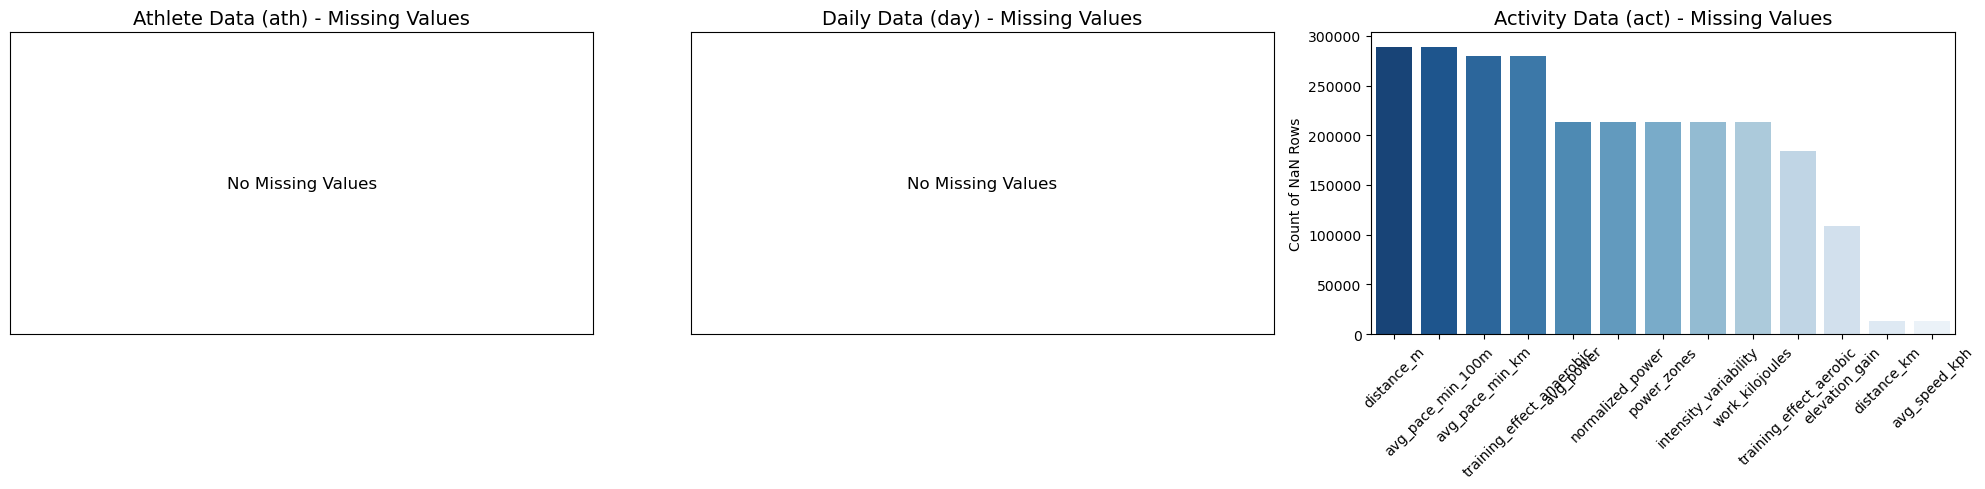

In [74]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Athlete Data (ath)")
print(f"Shape: {ath.shape}")
display(ath.head(3))

print("\nDaily Data (day)")
print(f"Shape: {day.shape}")
display(day.head(3))

print("\nActivity Data (act)")
print(f"Shape: {act.shape}")
display(act.head(3))

# Create Plots for Missing Data 
print("\nInitial Missing Value (NaN) Analysis")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Helper Function to Plot Missing Values with Seaborn 
def plot_missing_sns(df, title, ax):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    if missing_counts.empty:
        ax.text(0.5, 0.5, 'No Missing Values', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Bar plot using seaborn
        sns.barplot(x=missing_counts.index, 
                    y=missing_counts.values, 
                    ax=ax, 
                    palette="Blues_r",
                    hue=missing_counts.index,
                    legend=False,
                    dodge=False)  
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Count of NaN Rows')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
    return

# Plot
plot_missing_sns(ath, 'Athlete Data (ath) - Missing Values', axes[0])
plot_missing_sns(day, 'Daily Data (day) - Missing Values', axes[1])
plot_missing_sns(act, 'Activity Data (act) - Missing Values', axes[2])

plt.tight_layout()
plt.show()

## ============ Baseline Variables (from athlete.csv) ==================

Now we'll process the static `athletes.csv` file (`ath` DataFrame). This file contains baseline information about the athletes that doesn't change day-to-day, such as their training experience and lifestyle factors.

We will create:
* **Training_Experience**: A numeric value for their years of practice.
* **\_lifestyle\_score**: A derived composite score calculated as `Nutrition - Stress - Smoking - Drinking`.
* **Sex**: The athlete's sex, which will be used later.

In [75]:
# Node 1: Training_Experience
exp_col = find_col(ath, ["training_experience", "training_age","years_of_practice"], required=True)
ath["Training_Experience"] = pd.to_numeric(ath[exp_col], errors="coerce")

# Node 2: Lifestyle_Factor (Derived)
# Create an aggregated score: +Nutrition -Stress -Smoking -Drinking
nutri_col = find_col(ath, ["nutrition_factor", "nutrition"])
stress_col_base = find_col(ath, ["stress_factor", "stress"])
smoke_col = find_col(ath, ["smoking_factor", "smoking"])
drink_col = find_col(ath, ["drinking_factor", "alcohol"])
sex_col = find_col(ath, ["gender", "sex"], required=True)

ath["_lifestyle_score"] = 0.0
if nutri_col: ath["_lifestyle_score"] += pd.to_numeric(ath[nutri_col], errors='coerce').fillna(0)
if stress_col_base: ath["_lifestyle_score"] -= pd.to_numeric(ath[stress_col_base], errors='coerce').fillna(0)
if smoke_col: ath["_lifestyle_score"] -= pd.to_numeric(ath[smoke_col], errors='coerce').fillna(0)
if drink_col: ath["_lifestyle_score"] -= pd.to_numeric(ath[drink_col], errors='coerce').fillna(0)
ath["Sex"] = ath[sex_col]

## ============ Feature Engineering (from activity_data) ===============

This block focuses on the `activity_data.csv` file (`act` DataFrame). Its main purpose is to pre-calculate metrics for each *day* before merging with the main daily wellness dataframe.

We find the `intensity_factor` (or `if`) column and convert it to a numeric value. Then, we `groupby` athlete and date to calculate the **`Avg_Intensity`** for all activities performed on that day.

In [76]:
print("Aggregating activity data (for Avg_Intensity)...")

# Source for Node 8: Avg_Intensity
inten_col = find_col(act, ["intensity_factor","if"], required=True)
act["_intensity"] = pd.to_numeric(act[inten_col], errors="coerce")

# Aggregate by day/athlete
daily_agg = act.groupby(["athlete_id", "date"], as_index=False).agg(
    Avg_Intensity = ("_intensity", "mean") # Node 8
)

Aggregating activity data (for Avg_Intensity)...


## ================== Merge & Initial Inspection ======================

This is a critical step. We merge the `daily_data` (wellness) with the aggregated `activity_data` (load/intensity) using an **outer join**. This ensures we keep "Rest Days" (which exist in `day` but not `daily_agg`).

Then, we merge the static `athlete` data using a **left join**.

Finally, we will perform our first major **Exploratory Data Analysis (EDA)**. We'll check the `.info()` and `.isnull().sum()` of the fully merged DataFrame (`df`) to understand missing data patterns (like `NaN` values on rest days) *before* we start engineering complex features like ACWR or injury history.

Data Merging Process
Merge completed. Final DataFrame Shape: (366000, 44)


,athlete_id,date,resting_hr_day,hrv,sleep_hours,deep_sleep,light_sleep,rem_sleep,sleep_quality_day,body_battery_morning,...,lifestyle,sleep_time_norm,sleep_quality_ath,nutrition_factor,stress_factor,smoking_factor,drinking_factor,Training_Experience,_lifestyle_score,Sex
0,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-01,51.912317,90.872687,7.659744,1.096015,4.913882,1.649846,0.802,60.0,...,Balanced Competitor,7.937176,0.839725,0.818278,0.230409,0.0,0.121456,5,0.466413,male
1,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-02,50.246351,104.226122,7.961573,1.245846,4.936415,1.779312,0.841,97.0,...,Balanced Competitor,7.937176,0.839725,0.818278,0.230409,0.0,0.121456,5,0.466413,male
2,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-03,50.834952,102.297988,8.206464,1.280846,5.092240,1.833378,0.921,100.0,...,Balanced Competitor,7.937176,0.839725,0.818278,0.230409,0.0,0.121456,5,0.466413,male



Visualizing Missing Values (NaN) in Merged Data

Missing Values Count:
Avg_Intensity    90473
dtype: int64


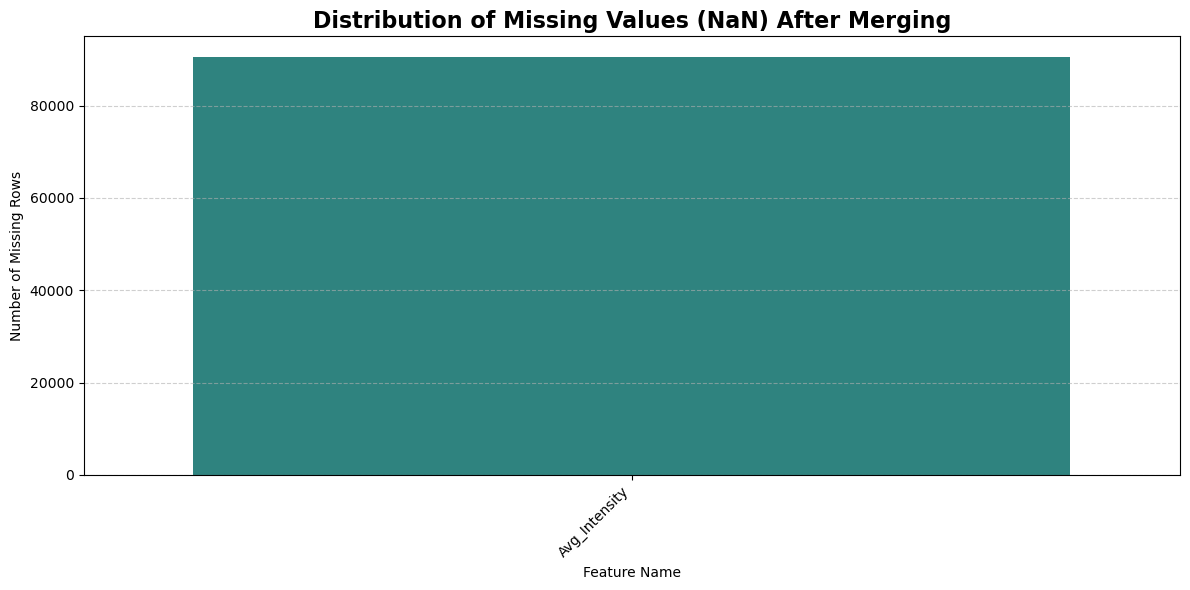

In [77]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

print("Data Merging Process")

# Merge daily wellness data (day) with aggregated activity data (daily_agg)
df = pd.merge(day, daily_agg, on=["athlete_id", "date"], how="outer")

# Merge with static athlete profile data (ath)
df = pd.merge(df, ath, on="athlete_id", how="left", suffixes=("_day", "_ath"))

# Sort data by athlete and date, then reset index
df = df.sort_values(["athlete_id", "date"]).reset_index(drop=True)

print(f"Merge completed. Final DataFrame Shape: {df.shape}")
display(df.head(3))

print("\nVisualizing Missing Values (NaN) in Merged Data")

# Calculate missing value counts
missing_counts = df.isnull().sum().sort_values(ascending=False)

# Filter to plot only columns that have missing data
missing_counts_to_plot = missing_counts[missing_counts > 0]

if missing_counts_to_plot.empty:
    print("DataFrame is complete: No missing values (NaN) found.")
else:
    print("\nMissing Values Count:")
    print(missing_counts_to_plot)

    plt.figure(figsize=(12, 6))
    
    # Create the Seaborn bar plot for missing values
    sns.barplot(x=missing_counts_to_plot.index, 
                y=missing_counts_to_plot.values, 
                palette="viridis", 
                hue=missing_counts_to_plot.index,
                legend=False,
                dodge=False)
    
    plt.title('Distribution of Missing Values (NaN) After Merging', fontsize=16, fontweight='bold')
    plt.ylabel('Number of Missing Rows')
    plt.xlabel('Feature Name')
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-labels for readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

> **Observation:** The `df.info()` and the bar chart show us exactly where the missing data is.
>
> 1.  **Partial `NaNs`**: The only column with missing data is `Avg_Intensity` (90,473 NaNs). This is expected and represents **Rest Days** (days present in `daily_data` but *not* in `activity_data` because no training occurred).
> 2.  **No `NaNs` in Wellness/Load**: Critically, all other columns, including `actual_tss`, `hrv`, `stress_day`, and `sleep_quality_day`, are fully populated. This is excellent.
>
> **Plan:** We will strategically fill `actual_tss` (which you've named `Training_Load`) with `0.0` *where it's missing*, although in your data, it's already full. The script *will* fill `Avg_Intensity` NaNs later during discretization. The most important next step is to proceed with calculating the time-based features like ACWR and injury history.

## =================== Feature Engineering (Post-Merge) ===================

This is the core of the feature engineering. We will now use the merged data to create the key variables for our model.

1.  **Daily Metrics**: We find and standardize the names for key wellness and load columns (`Sleep_Quality`, `Morning_HRV`, `Daily_Stress`, `Training_Load`, `Injury_Risk`).
2.  **Static Factors**: We calculate `BMI` from the athlete's height and weight.
3.  **Training Load**: We fill `NaN` values in `Training_Load` with `0.0` to ensure rest days are counted as zero load, which is critical for the next step.
4.  **ACWR**: We calculate the `Acute_Chronic_Ratio` (Node 9) by dividing the 7-day rolling average load by the 28-day rolling average load.
5.  **Readiness**: We create a composite `_ready_score` (Node 6) by combining the Z-scores of sleep, HRV, and stress.
6.  **Injury History**: We create two crucial *lagged* features to prevent data leakage:
    * `Injury_Prev30d` (Node 11): A rolling *max* over 30 days, shifted by 1, to see if an injury occurred in the past month.
    * `Injury_History_12m` (Node 12): A rolling *sum* over 365 days, shifted by 1, to count the total number of injury days in the past year.

In [78]:
print("Calculating derived features...")

# --- Daily Load & Wellness ---
sleep_q_col = find_col(df, ["sleep_quality_day", "sleep_quality","sleep_score"], required=True)
hrv_col = find_col(df, ["hrv", "hrv_ms","rmssd_ms","hrv_morning"], required=True)
stress_col_day = find_col(df, ["stress_day", "stress","stress_score"], required=True)
load_col = find_col(df, ["actual_tss", "tss"], required=True)
inj_col = find_col(df, ["injury","injured"], required=True)

df["Sleep_Quality"] = pd.to_numeric(df[sleep_q_col], errors="coerce")
df["Morning_HRV"]   = pd.to_numeric(df[hrv_col], errors="coerce")
df["Daily_Stress"]  = pd.to_numeric(df[stress_col_day], errors="coerce")
df["Training_Load"] = pd.to_numeric(df[load_col], errors="coerce")
df["Injury_Risk"]   = pd.to_numeric(df[inj_col], errors="coerce").fillna(0).clip(0,1).astype(int)

# --- Static Baseline Factors (Age, BMI, Sex) ---
age_col = find_col(df, ["age_ath", "age"], required=True) 
df["Age"] = pd.to_numeric(df[age_col], errors="coerce")
sex_col_final = find_col(df, ["Sex_ath", "Sex", "gender_ath"], required=True)
df["Sex_Source"] = df[sex_col_final]
h_col = find_col(df, ["height_cm_ath","height_cm"], required=True)
w_col = find_col(df, ["weight_kg_ath","weight_kg"], required=True)
df["height_m"] = pd.to_numeric(df[h_col], errors="coerce") / 100.0
df["weight_kg"] = pd.to_numeric(df[w_col], errors="coerce")
df["BMI"] = df["weight_kg"] / (df["height_m"]**2)


# Fill 0 for rest days (IMPORTANT: do this before rolling means)
df["Training_Load"] = df["Training_Load"].fillna(0.0)

# Node 9: Acute_Chronic_Ratio
df["_load_7d_mean"] = grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 7)
df["_load_28d_mean"]= grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 28)
df["Acute_Chronic_Ratio"] = df["_load_7d_mean"] / df["_load_28d_mean"]
df["Acute_Chronic_Ratio"] = df["Acute_Chronic_Ratio"].replace([np.inf, -np.inf], np.nan)

# Node 6: Ready_To_Train (Composite Z-score)
z_sleep = zscore_by_group(df["Sleep_Quality"], df["athlete_id"])
z_hrv = zscore_by_group(df["Morning_HRV"], df["athlete_id"])
z_stress = zscore_by_group(df["Daily_Stress"], df["athlete_id"])
df["_ready_score"] = z_sleep.fillna(0) + z_hrv.fillna(0) - z_stress.fillna(0)


# --- INJURY PREDICTORS (NEW CRUCIAL NODES) ---
# Node 11: Injury_Prev30d (Rolling max on 30 days, shifted by 1)
df["Injury_Prev30d"] = (df
    .groupby("athlete_id")["Injury_Risk"]
    .rolling(30, min_periods=1).max()
    .reset_index(level=0, drop=True)
).shift(1).fillna(0).astype(int)

# Node 12: Injury_History_12m (Rolling sum on 365 days, shifted by 1)
hist_365 = (df
    .groupby("athlete_id")["Injury_Risk"]
    .rolling(365, min_periods=1).sum()
    .reset_index(level=0, drop=True)
).shift(1).fillna(0)

Calculating derived features...


### Visualize Continuous Distributions (Pre-Discretization)

Before discretizing, let's look at the distributions of the key continuous variables. This helps us choose the right binning strategy (e.g., `pd.cut` for `BMI`, or `pd.qcut` for skewed data like `hist_365`).

*(Note: We plot `hist_365` here, which was calculated in the previous step but is not yet a column in `df`)*

Plotting continuous variable distributions...


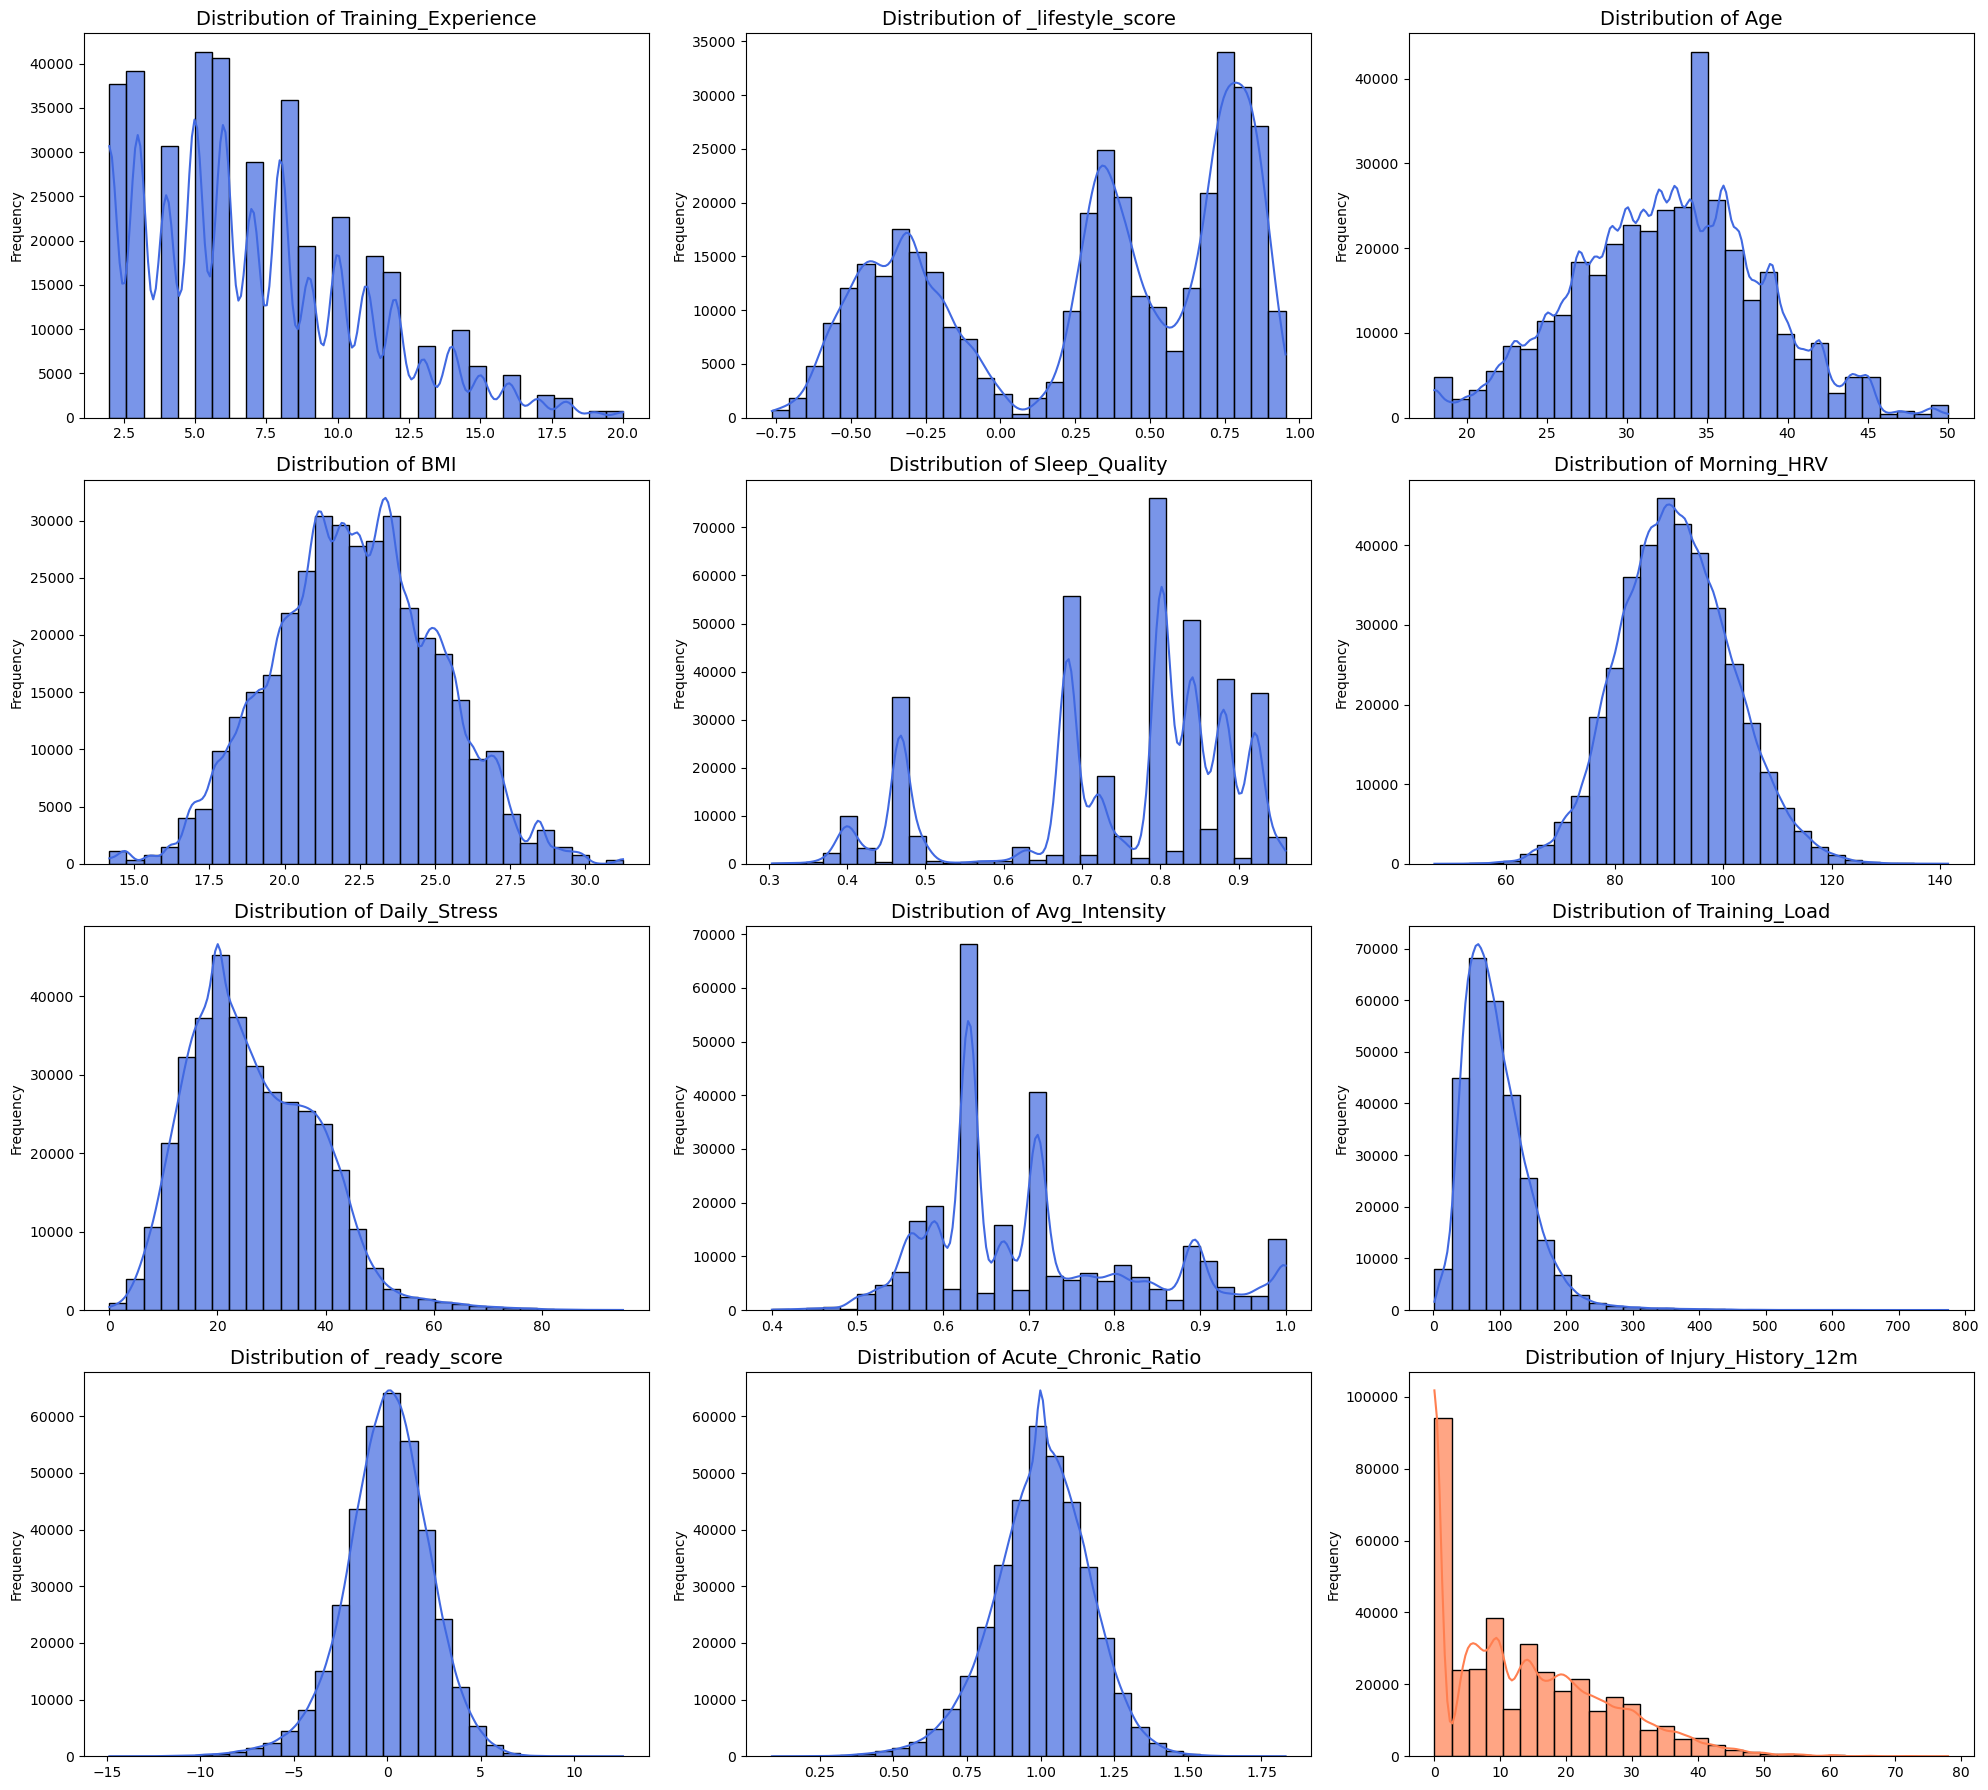

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select key continuous variables to plot
# We'll plot the raw versions before Z-scoring or binning
vars_to_plot = [
    "Training_Experience", "_lifestyle_score", "Age", "BMI",
    "Sleep_Quality", "Morning_HRV", "Daily_Stress",
    "Avg_Intensity", "Training_Load", "_ready_score", "Acute_Chronic_Ratio"
]

# Create histograms
# Filter out zeros from Training_Load for a more informative plot
plot_df = df[vars_to_plot].copy()
plot_df["Training_Load"] = plot_df["Training_Load"].replace(0, np.nan) # Exclude rest days from this plot

# Use matplotlib to create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 18))
axes = axes.flatten()

print("Plotting continuous variable distributions...")

for i, col in enumerate(vars_to_plot):
    if col in plot_df:

        sns.histplot(plot_df[col].dropna(), ax=axes[i], kde=True, bins=30, color='royalblue', alpha=0.7)
        
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

# Plot hist_365 (Injury_History_12m) separately
sns.histplot(hist_365.dropna(), ax=axes[i+1], kde=True, bins=30, color='coral', alpha=0.7)
axes[i+1].set_title('Distribution of Injury_History_12m', fontsize=14)
axes[i+1].set_xlabel('')
axes[i+1].set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 2, len(axes)): 
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## ======================== Discretization =============================

Now that the features are engineered, we must **discretize** them. Bayesian Networks require categorical data (e.g., "Low", "Medium", "High") instead of continuous numbers (e.g., 8.34).

We will use two different methods:
1.  **`pd.cut` (Fixed Bins)**: Used for variables with known clinical or practical ranges, like `Age` ("Young", "Adult", "Veteran") and `BMI` ("Underweight", "Normal", etc.).
2.  **`pd.qcut` (Quantile Bins)**: Used for most other variables (`Sleep_Quality`, `Training_Load`, `hist_365`). This method automatically finds bin edges that result in groups of (roughly) equal size. This is crucial for heavily skewed data, like `Injury_History_12m` (where most values are zero), to ensure we get meaningful "Low Risk", "Medium Risk", and "High Risk" categories.
3.  **Custom Logic**: `Acute_Chronic_Ratio` is binned based on established "danger zones" (< 0.8 or > 1.3).

In [80]:
print("Discretizing all 15 variables...")
df_out = pd.DataFrame()
df_out["athlete_id"] = df["athlete_id"]
df_out["date"] = df["date"]

# Long-Term Factors (5 Nodes) 
df_out["Training_Experience"] = discretize_qcut(df["Training_Experience"], q=3, labels=["Low", "Medium", "High"])
df_out["Lifestyle_Factor"] = discretize_qcut(df["_lifestyle_score"], q=3, labels=["Negative", "Neutral", "Positive"])
df_out["Age_d"] = pd.cut(df["Age"], 
                         bins=[-np.inf, 25, 35, np.inf], 
                         labels=["Young (<25)", "Adult (25-35)", "Veteran (>35)"])
df_out["BMI_d"] = pd.cut(df["BMI"], 
                         bins=[0, 18.5, 25, 30, np.inf], 
                         labels=["Underweight", "Normal", "Overweight", "Obese"])
df_out["Sex_d"] = df["Sex_Source"].astype(str).str.lower().map(
    {'male': 'Male', 'female': 'Female'}
).fillna('Missing').astype('category')


# Dynamic Predictors (5 Nodes) 
df_out["Sleep_Quality"] = discretize_qcut(df["Sleep_Quality"], q=3, labels=["Poor", "Good", "Great"])
df_out["Morning_HRV"] = discretize_qcut(z_hrv, q=3, labels=["Low", "Normal", "High"])
df_out["Daily_Stress"] = discretize_qcut(df["Daily_Stress"], q=3, labels=["Low", "Medium", "High"])
df_out["Avg_Intensity"] = discretize_qcut(df["Avg_Intensity"], q=3, labels=["Low", "Medium", "High"])
df_out["Training_Load"] = discretize_qcut(df["Training_Load"].replace(0, np.nan), q=3, labels=["Low", "Medium", "High"])

# Hubs and History (4 Nodes)
df_out["Ready_To_Train"] = discretize_qcut(df["_ready_score"], q=2, labels=["No", "Yes"])
df_out["Acute_Chronic_Ratio"] = "Low (Good)" 
df_out.loc[(df['Acute_Chronic_Ratio'] < 0.8) | (df['Acute_Chronic_Ratio'] > 1.3), 'Acute_Chronic_Ratio'] = 'Risk (High)'
df_out.loc[df['Acute_Chronic_Ratio'].isna(), 'Acute_Chronic_Ratio'] = np.nan 

# INJURY HISTORY NODES --- LOGIC FIX FOR IMBALANCE (using quantiles for optimal split) ---
# We use qcut/quantile-based bins to find the optimal thresholds for homogeneous grouping.
# This ensures that the risk tiers (Low, Medium, High) are evenly sized in the dataset.

# Calculate Quantile Bins for 3 equal frequency groups (Optimal Homogeneous Discretization)
q_bins = hist_365.quantile([0.0, 0.333, 0.666, 1.0]).unique().tolist()
# Ensure the first bin starts below the minimum possible value (0)
if q_bins[0] > -0.1:
    q_bins[0] = -0.1 

# If only 2 unique bins are returned (due to large clusters at 0 or other values), 
# use only 2 labels.
q_labels = ["Low Risk", "Medium Risk", "High Risk"] 

# Use pd.cut with the calculated quantile bins
df_out["Injury_History_12m"] = pd.cut(hist_365, 
                                 bins=q_bins,
                                 labels=q_labels[:len(q_bins)-1],
                                 include_lowest=True,
                                 duplicates='drop').astype('category')

df_out["Injury_Prev30d"] = df["Injury_Prev30d"].map({0: "No", 1: "Yes"}).astype('category')

# Outcome (1 Node)
df_out["Injury_Risk"] = df["Injury_Risk"].map({0: "No", 1: "Yes"})

Discretizing all 15 variables...


### Verify Discretized Distributions (EDA)

Let's check the result of our discretization using bar charts (count plots). We want to ensure our categories are relatively balanced and that the `qcut` strategy worked. This also gives us a clear look at our target variable, `Injury_Risk`.

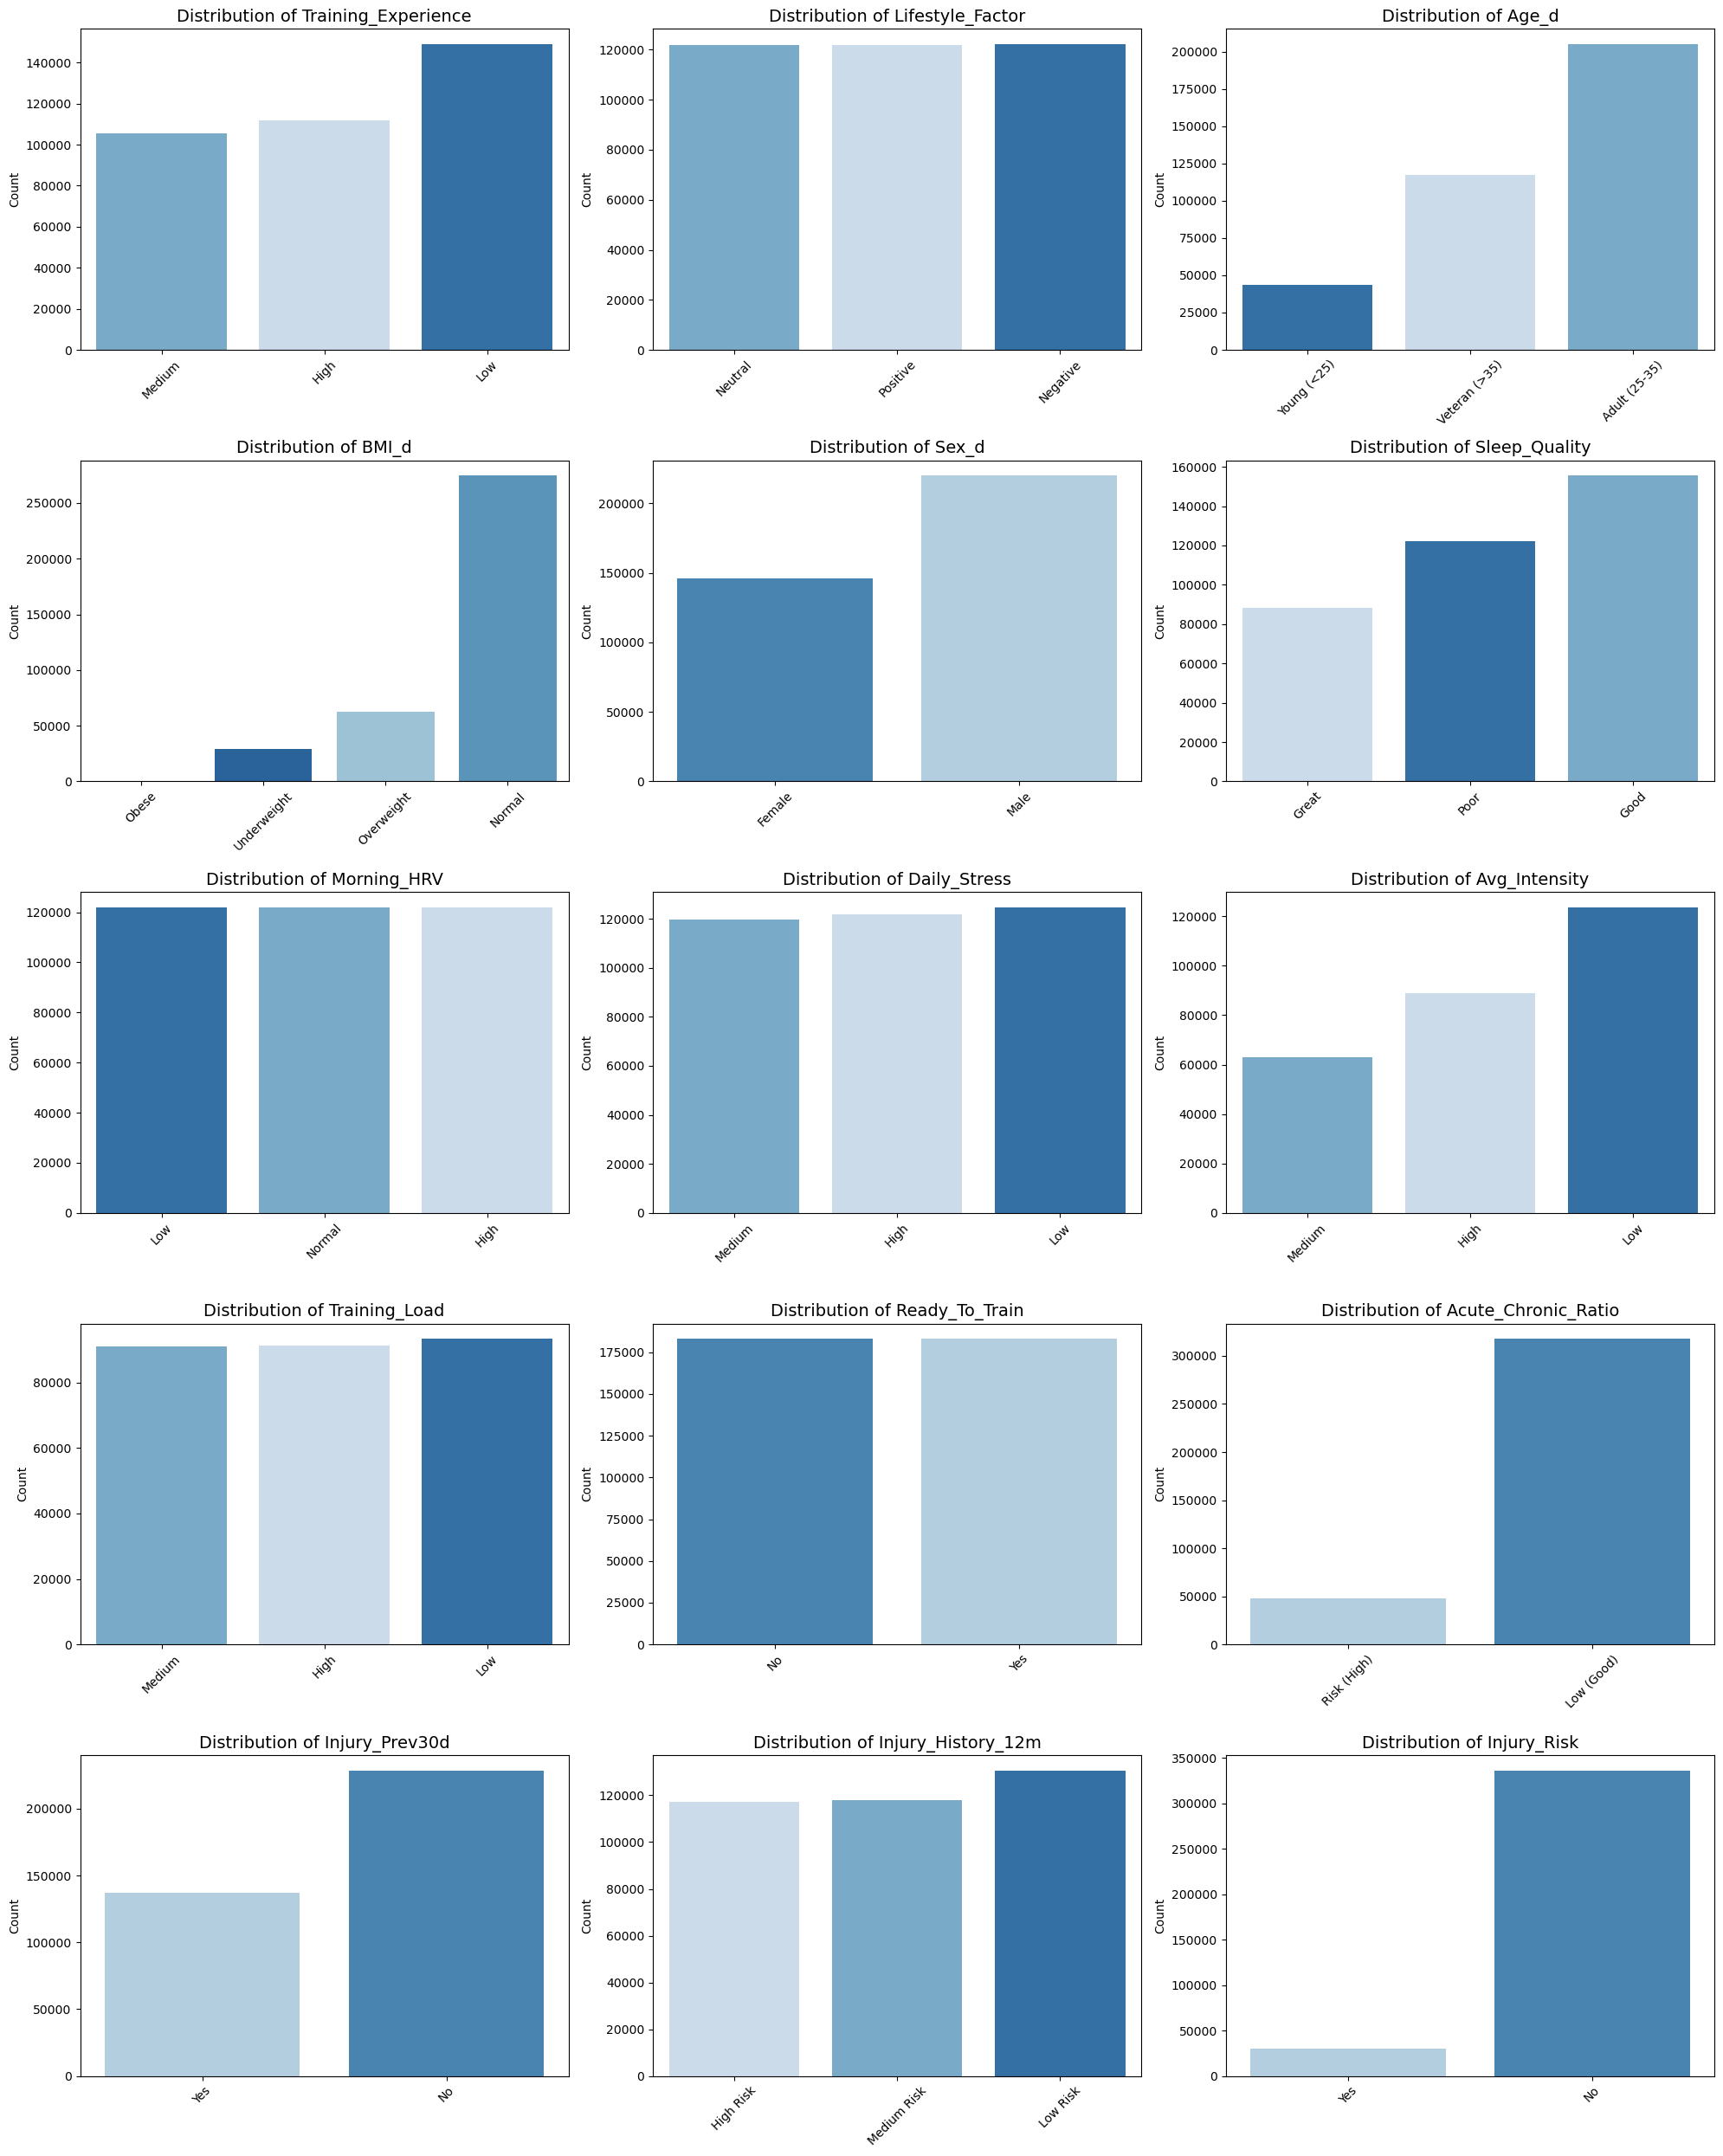

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the new discrete columns
discrete_cols_to_plot = [
    "Training_Experience", "Lifestyle_Factor", "Age_d", "BMI_d", "Sex_d",
    "Sleep_Quality", "Morning_HRV", "Daily_Stress", "Avg_Intensity",
    "Training_Load", "Ready_To_Train", "Acute_Chronic_Ratio",
    "Injury_Prev30d", "Injury_History_12m", "Injury_Risk"
]

# Create count plots (bar charts)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(discrete_cols_to_plot):
    if col in df_out:
        
        # Order by frequency (from smallest to largest)
        order = df_out[col].value_counts(ascending=True).index
        
        sns.countplot(data=df_out, x=col, ax=axes[i], 
                      palette='Blues_r', order=order, 
                      hue=col, legend=False, dodge=False) 
        
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('') # Rimuovi la label x
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##  ==================== NaN Handling for BN =====================

Discrete Bayesian Networks cannot handle `NaN` (missing) values. This is a common issue for variables like `Training_Load` (on rest days before we filled them) or `Avg_Intensity` (which is still `NaN` on rest days).

To fix this, we will convert any remaining `NaNs` in our final 15 discrete columns into an explicit string category called **"Missing"**. This allows the model to learn the probability of data being missing and how that state influences other nodes.

In [82]:
# Discrete Bayesian networks do not handle NaNs.
# We convert NaNs to an explicit "Missing" category.

discrete_cols = [
    "Training_Experience", "Lifestyle_Factor", 
    "Age_d", "BMI_d", "Sex_d", 
    "Sleep_Quality", "Morning_HRV", "Daily_Stress",
    "Avg_Intensity", "Training_Load", # Dynamic Inputs
    "Ready_To_Train", "Acute_Chronic_Ratio", 
    "Injury_Prev30d", "Injury_History_12m", # Injury History
    "Injury_Risk"
]

print("Converting NaNs to 'Missing' for all 15 discrete variables...")
for col in discrete_cols:
    if col not in df_out.columns:
        print(f"Warning: Column {col} not found for fillna.")
        continue
    if not isinstance(df_out[col].dtype, pd.CategoricalDtype):
         df_out[col] = df_out[col].astype('category')
    
    if df_out[col].isnull().any():
        if "Missing" not in df_out[col].cat.categories:
            df_out[col] = df_out[col].cat.add_categories("Missing")
        df_out[col] = df_out[col].fillna("Missing")

Converting NaNs to 'Missing' for all 15 discrete variables...


## ============================== Export ====================================

Finally, we select only the 15 discretized columns (plus `athlete_id` and `date`) and export the final, preprocessed DataFrame to **`bn_preprocessed.csv`**.

This file is now clean, fully discretized, contains no `NaN` values, and is ready for modeling.

In [83]:
cols_keep = [
    "athlete_id", "date",
    "Training_Experience", "Lifestyle_Factor", 
    "Age_d", "BMI_d", "Sex_d", 
    "Sleep_Quality", "Morning_HRV", "Daily_Stress", 
    "Avg_Intensity", "Training_Load", 
    "Ready_To_Train", "Acute_Chronic_Ratio",
    "Injury_Prev30d", "Injury_History_12m", 
    "Injury_Risk"
]

# Keep only the columns that actually exist
cols_keep_final = [c for c in cols_keep if c in df_out.columns]
df_final = df_out[cols_keep_final].copy()

df_final.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV} — rows: {len(df_final):,}")
print(f"Generated columns (15 total): {list(df_final.columns)[2:]}")

# Final step: Execute


Saved: bn_preprocessed.csv — rows: 366,000
Generated columns (15 total): ['Training_Experience', 'Lifestyle_Factor', 'Age_d', 'BMI_d', 'Sex_d', 'Sleep_Quality', 'Morning_HRV', 'Daily_Stress', 'Avg_Intensity', 'Training_Load', 'Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d', 'Injury_History_12m', 'Injury_Risk']
